<a href="https://colab.research.google.com/github/verykurniabakti/cv/blob/master/02EkstraksifiturFFT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# --- Prakonfigurasi ---
import numpy as np
import pandas as pd
from scipy.fft import fft
import matplotlib.pyplot as plt

df = pd.read_csv("data_ka_siap.csv")


In [ ]:
# --- Definisikan Fungsi Ekstraksi FFT ---
# ambil energi spektral dan frekuensi dominan (2 fitur per sinyal)
def extract_fft_features(signal, fs=50):
    N = len(signal)
    freq = np.fft.fftfreq(N, d=1/fs)
    fft_vals = np.abs(fft(signal))[:N//2]
    fft_freqs = freq[:N//2]

    dominant_freq = fft_freqs[np.argmax(fft_vals)]
    spectral_energy = np.sum(fft_vals**2)
    return dominant_freq, spectral_energy

In [4]:
# --- Sliding window
# Supaya FFT punya konteks temporal
def create_fft_feature_set(df, window_size=128, step=64):
    features = []
    labels = []
    for start in range(0, len(df) - window_size, step):
        window = df.iloc[start:start+window_size]
        label = window['label'].mode()[0]

        feats = []
        for col in ['ax','ay','az','gx','gy','gz']:
            dom_freq, energy = extract_fft_features(window[col].values)
            feats.extend([dom_freq, energy])
        features.append(feats)
        labels.append(label)

    columns = [f"{axis}_{f}" for axis in ['ax','ay','az','gx','gy','gz'] for f in ['dom_freq','energy']]
    return pd.DataFrame(features, columns=columns), labels


In [5]:
# Hasilkan Dataset Fitur FFT
X_fft, y_fft = create_fft_feature_set(df)
X_fft['label'] = y_fft
X_fft.head()


,ax_dom_freq,ax_energy,ay_dom_freq,ay_energy,az_dom_freq,az_energy,gx_dom_freq,gx_energy,gy_dom_freq,gy_energy,gz_dom_freq,gz_energy,label
0,18.359375,145.810431,23.828125,304.424245,0.00000,1372.263263,7.031250,129.087672,7.8125,346.983466,20.312500,2344.479166,1
1,14.843750,507.463416,13.671875,466.085177,22.65625,1706.906619,20.703125,26.534392,0.0000,153.300681,20.312500,596.362723,1
2,14.062500,732.700740,12.890625,660.380224,0.78125,2770.244109,0.000000,7591.035333,0.0000,2327.020362,20.703125,855.528508,1
3,23.437500,373.944440,17.187500,379.807924,0.00000,7853.786772,0.000000,64854.110050,0.0000,19471.937253,0.000000,1223.739433,0
4,0.000000,109.092337,0.000000,6.334809,0.00000,15152.062256,0.000000,133743.166772,0.0000,40771.460103,0.000000,1611.918707,0


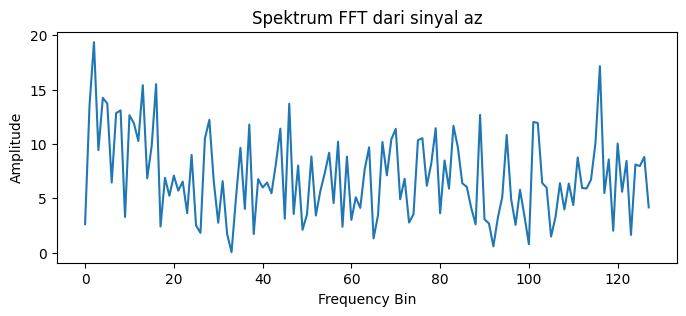

In [6]:
# --- Visualisasi FFT Sinyal ---
signal = df['az'][:256]
plt.figure(figsize=(8, 3))
plt.plot(np.abs(fft(signal))[:128])
plt.title("Spektrum FFT dari sinyal az")
plt.xlabel("Frequency Bin")
plt.ylabel("Amplitude")
plt.show()


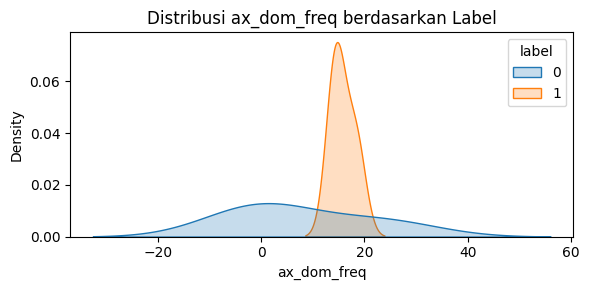

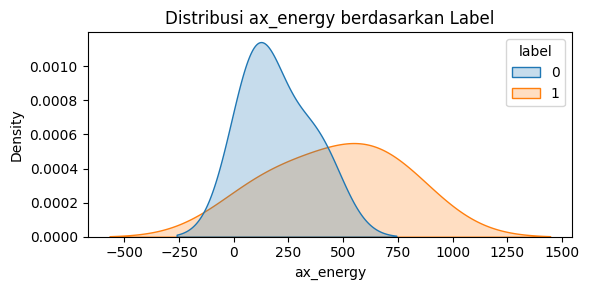

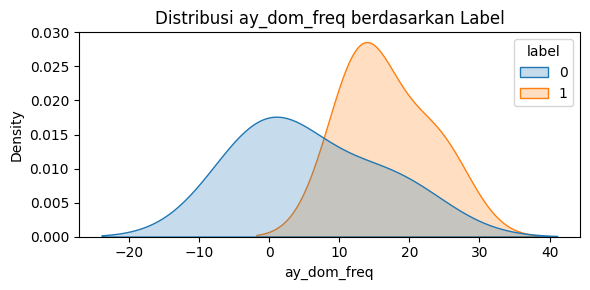

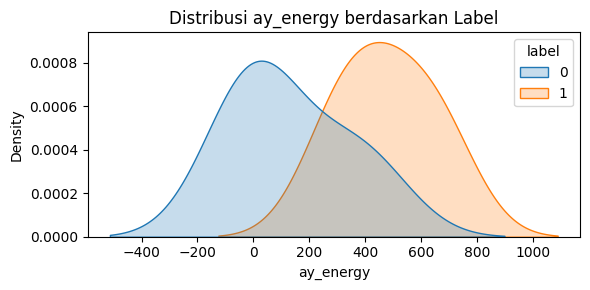

/tmp/ipython-input-7-3050112030.py:12: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=X_fft, x=col, hue='label', fill=True)


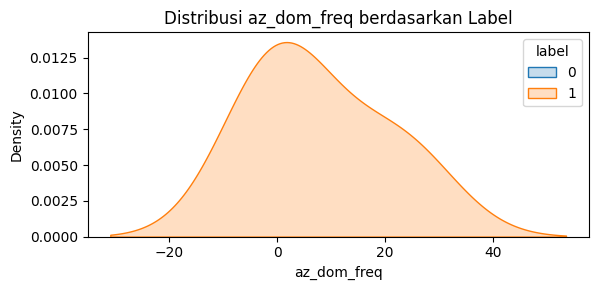

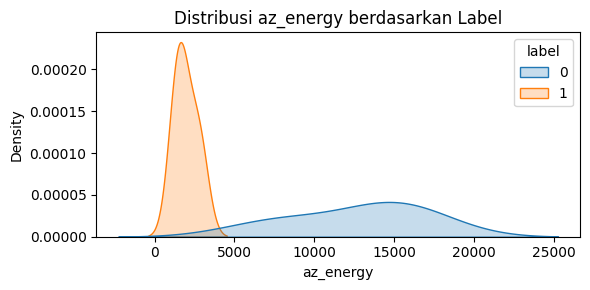

/tmp/ipython-input-7-3050112030.py:12: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=X_fft, x=col, hue='label', fill=True)


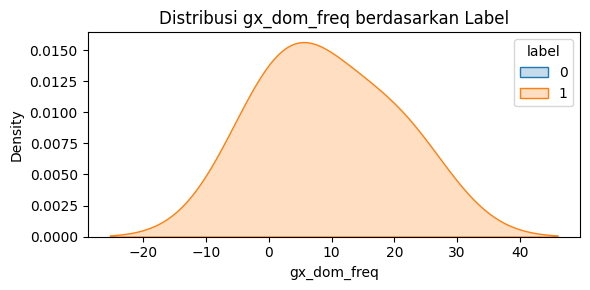

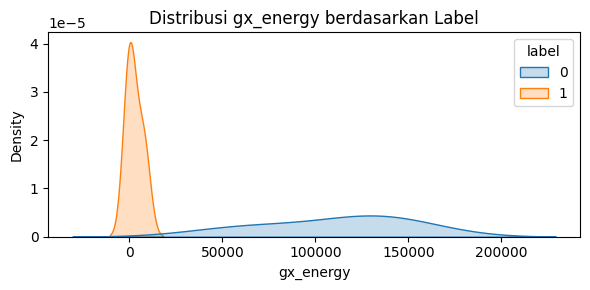

/tmp/ipython-input-7-3050112030.py:12: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=X_fft, x=col, hue='label', fill=True)


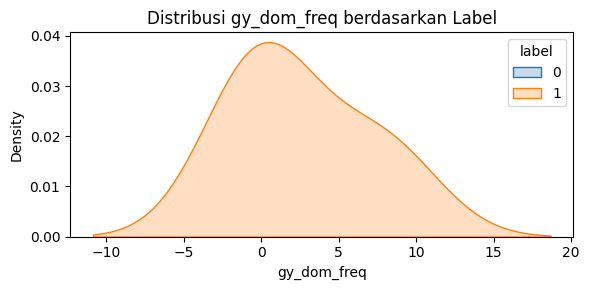

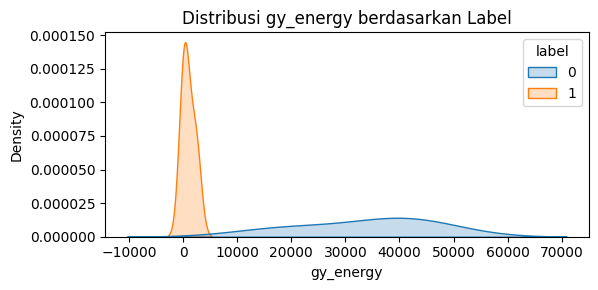

/tmp/ipython-input-7-3050112030.py:12: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=X_fft, x=col, hue='label', fill=True)


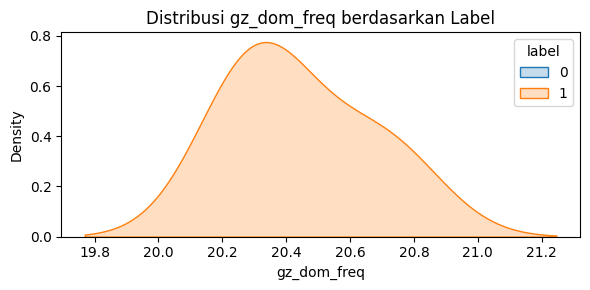

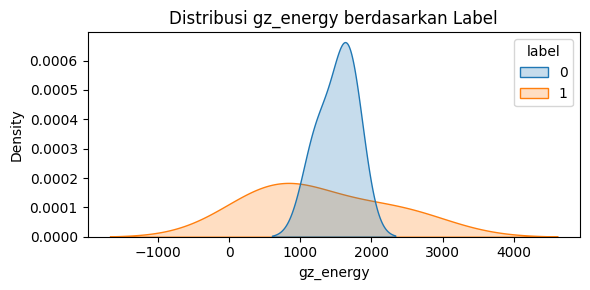

In [7]:
# --- Eksplorasi FFT ---
# Setiap sensor (ax, ay, az, gx, gy, gz) menghasilkan:
# dom_freq: frekuensi dominan
# energy: total energi sinyal dalam domain frekuensi
# --- Distribusi Histogram & KDE Plot
import seaborn as sns
import matplotlib.pyplot as plt

fft_features = X_fft.drop(columns='label').columns
for col in fft_features:
    plt.figure(figsize=(6,3))
    sns.kdeplot(data=X_fft, x=col, hue='label', fill=True)
    plt.title(f'Distribusi {col} berdasarkan Label')
    plt.tight_layout()
    plt.show()


In [ ]:
# --- Boxplot untuk Perbandingan langsung ---

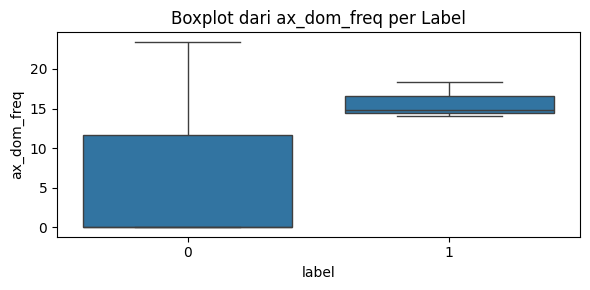

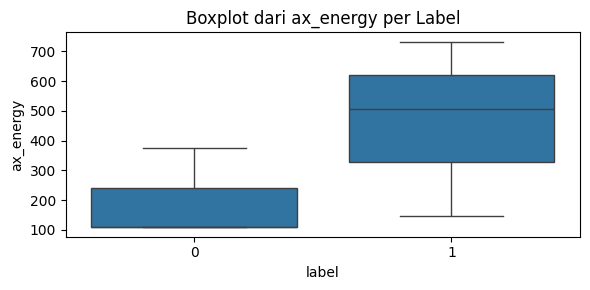

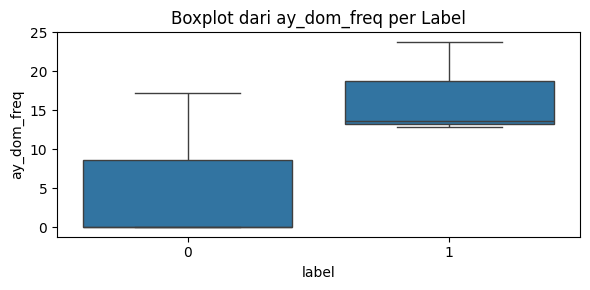

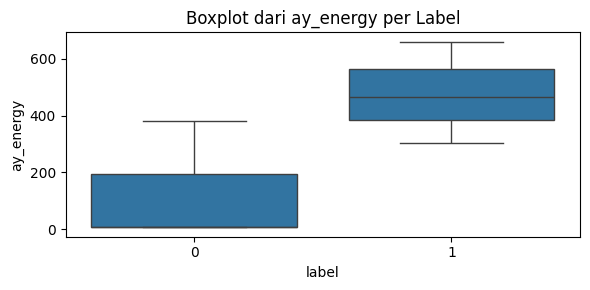

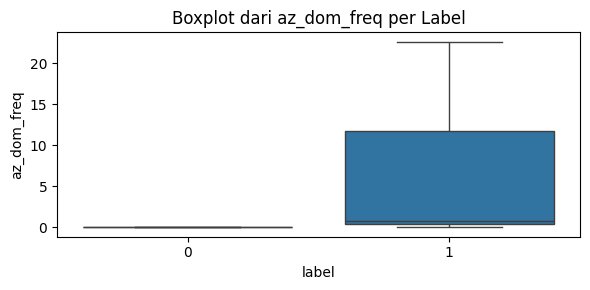

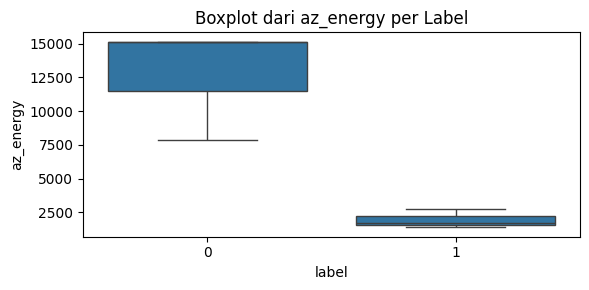

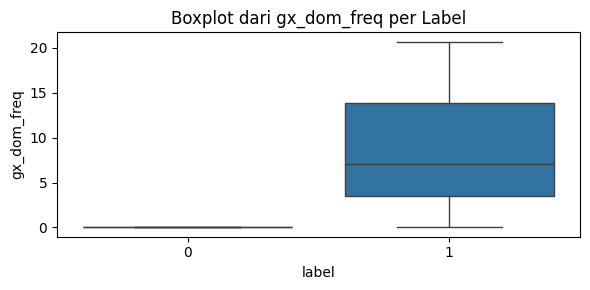

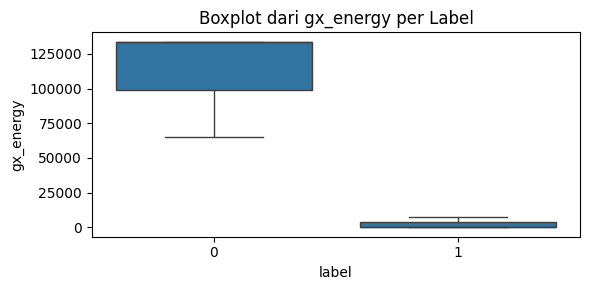

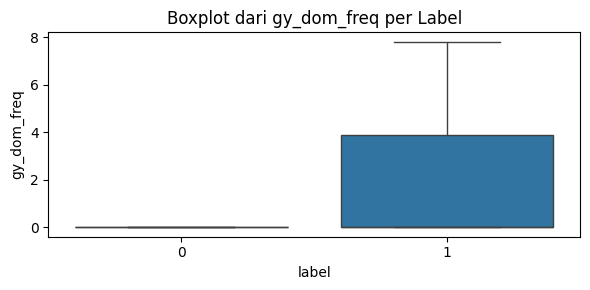

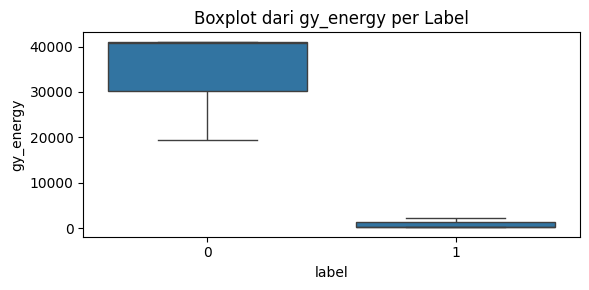

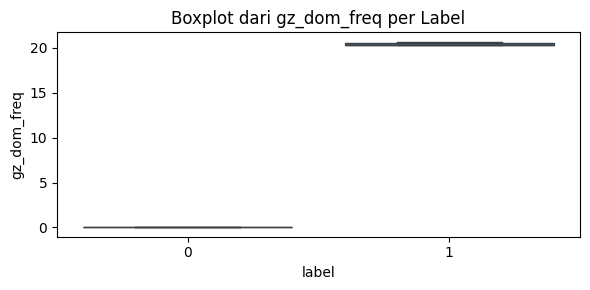

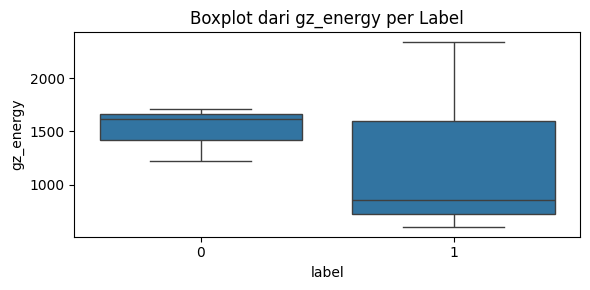

In [8]:
for col in fft_features:
    plt.figure(figsize=(6,3))
    sns.boxplot(data=X_fft, x='label', y=col)
    plt.title(f'Boxplot dari {col} per Label')
    plt.tight_layout()
    plt.show()


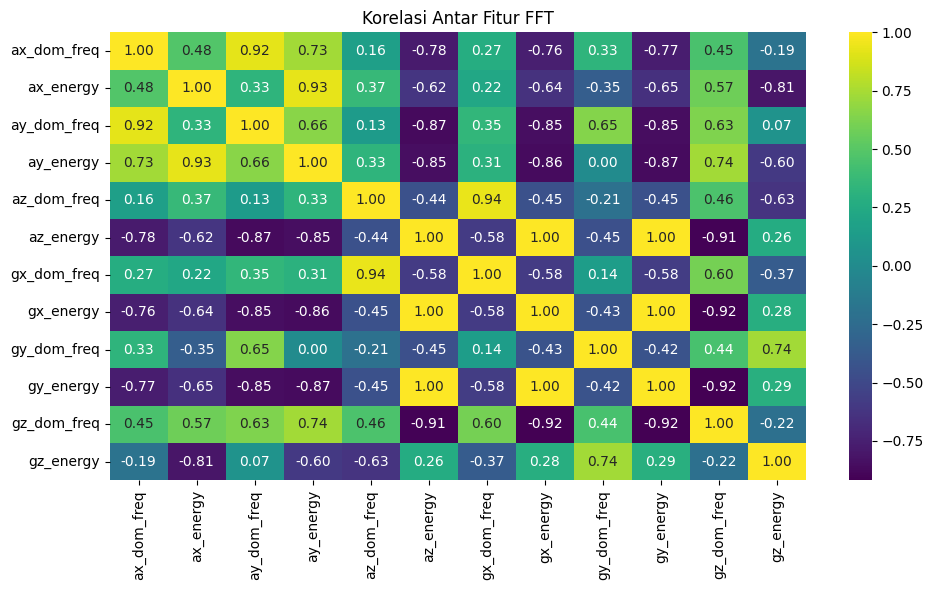

In [9]:
# --- Heatmap Korelasi Antar Fitur Frekuensi ---
import numpy as np

plt.figure(figsize=(10,6))
sns.heatmap(X_fft[fft_features].corr(), annot=True, fmt=".2f", cmap='viridis')
plt.title("Korelasi Antar Fitur FFT")
plt.tight_layout()
plt.show()


In [10]:
# --- Uji Statistik untuk Signifikansi ---
# Gunakan t-test untuk melihat apakah distribusi antar label secara statistik berbeda
# Nilai p yang kecil (misal < 0.05) menunjukkan bahwa fitur tersebut punya potensi sebagai pemisah antar kelas.
from scipy.stats import ttest_ind

for col in fft_features:
    group0 = X_fft[X_fft['label'] == 0][col]
    group1 = X_fft[X_fft['label'] == 1][col]
    stat, p = ttest_ind(group0, group1, equal_var=False)
    print(f"{col} - p-value: {p:.5f}")


ax_dom_freq - p-value: 0.41679
ax_energy - p-value: 0.26246
ay_dom_freq - p-value: 0.18949
ay_energy - p-value: 0.10118
az_dom_freq - p-value: 0.40310
az_energy - p-value: 0.04375
gx_dom_freq - p-value: 0.26765
gx_energy - p-value: 0.04068
gy_dom_freq - p-value: 0.42265
gy_energy - p-value: 0.04317
gz_dom_freq - p-value: 0.00004
gz_energy - p-value: 0.69554


In [11]:
# --- INSIGHT ---
# Fitur seperti az_dom_freq atau gz_energy sering kali punya karakteristik berbeda untuk pola getaran atau rotasi antara dua kondisi
# Korelasi antar sumbu bisa bantu kurangi redudansi fitur sebelum modeling.